# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/train.csv")

df.drop(columns = ["id", "player_id"], inplace = True)
df.drop(columns = ["random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101658 entries, 0 to 101657
Data columns (total 42 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   play_frequency                    93785 non-null   float64
 1   avg_session_duration              93771 non-null   float64
 2   total_playtime_hours              93887 non-null   float64
 3   login_streak                      93938 non-null   float64
 4   days_since_last_login             93878 non-null   float64
 5   total_spending_thb                93902 non-null   float64
 6   avg_monthly_spending              93923 non-null   float64
 7   spending_frequency                93898 non-null   float64
 8   friend_count                      93720 non-null   float64
 9   team_play_percentage              93963 non-null   float64
 10  chat_activity_score               93893 non-null   float64
 11  friend_invites_sent               93823 non-null   f

/tmp/ipykernel_47/2895113624.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


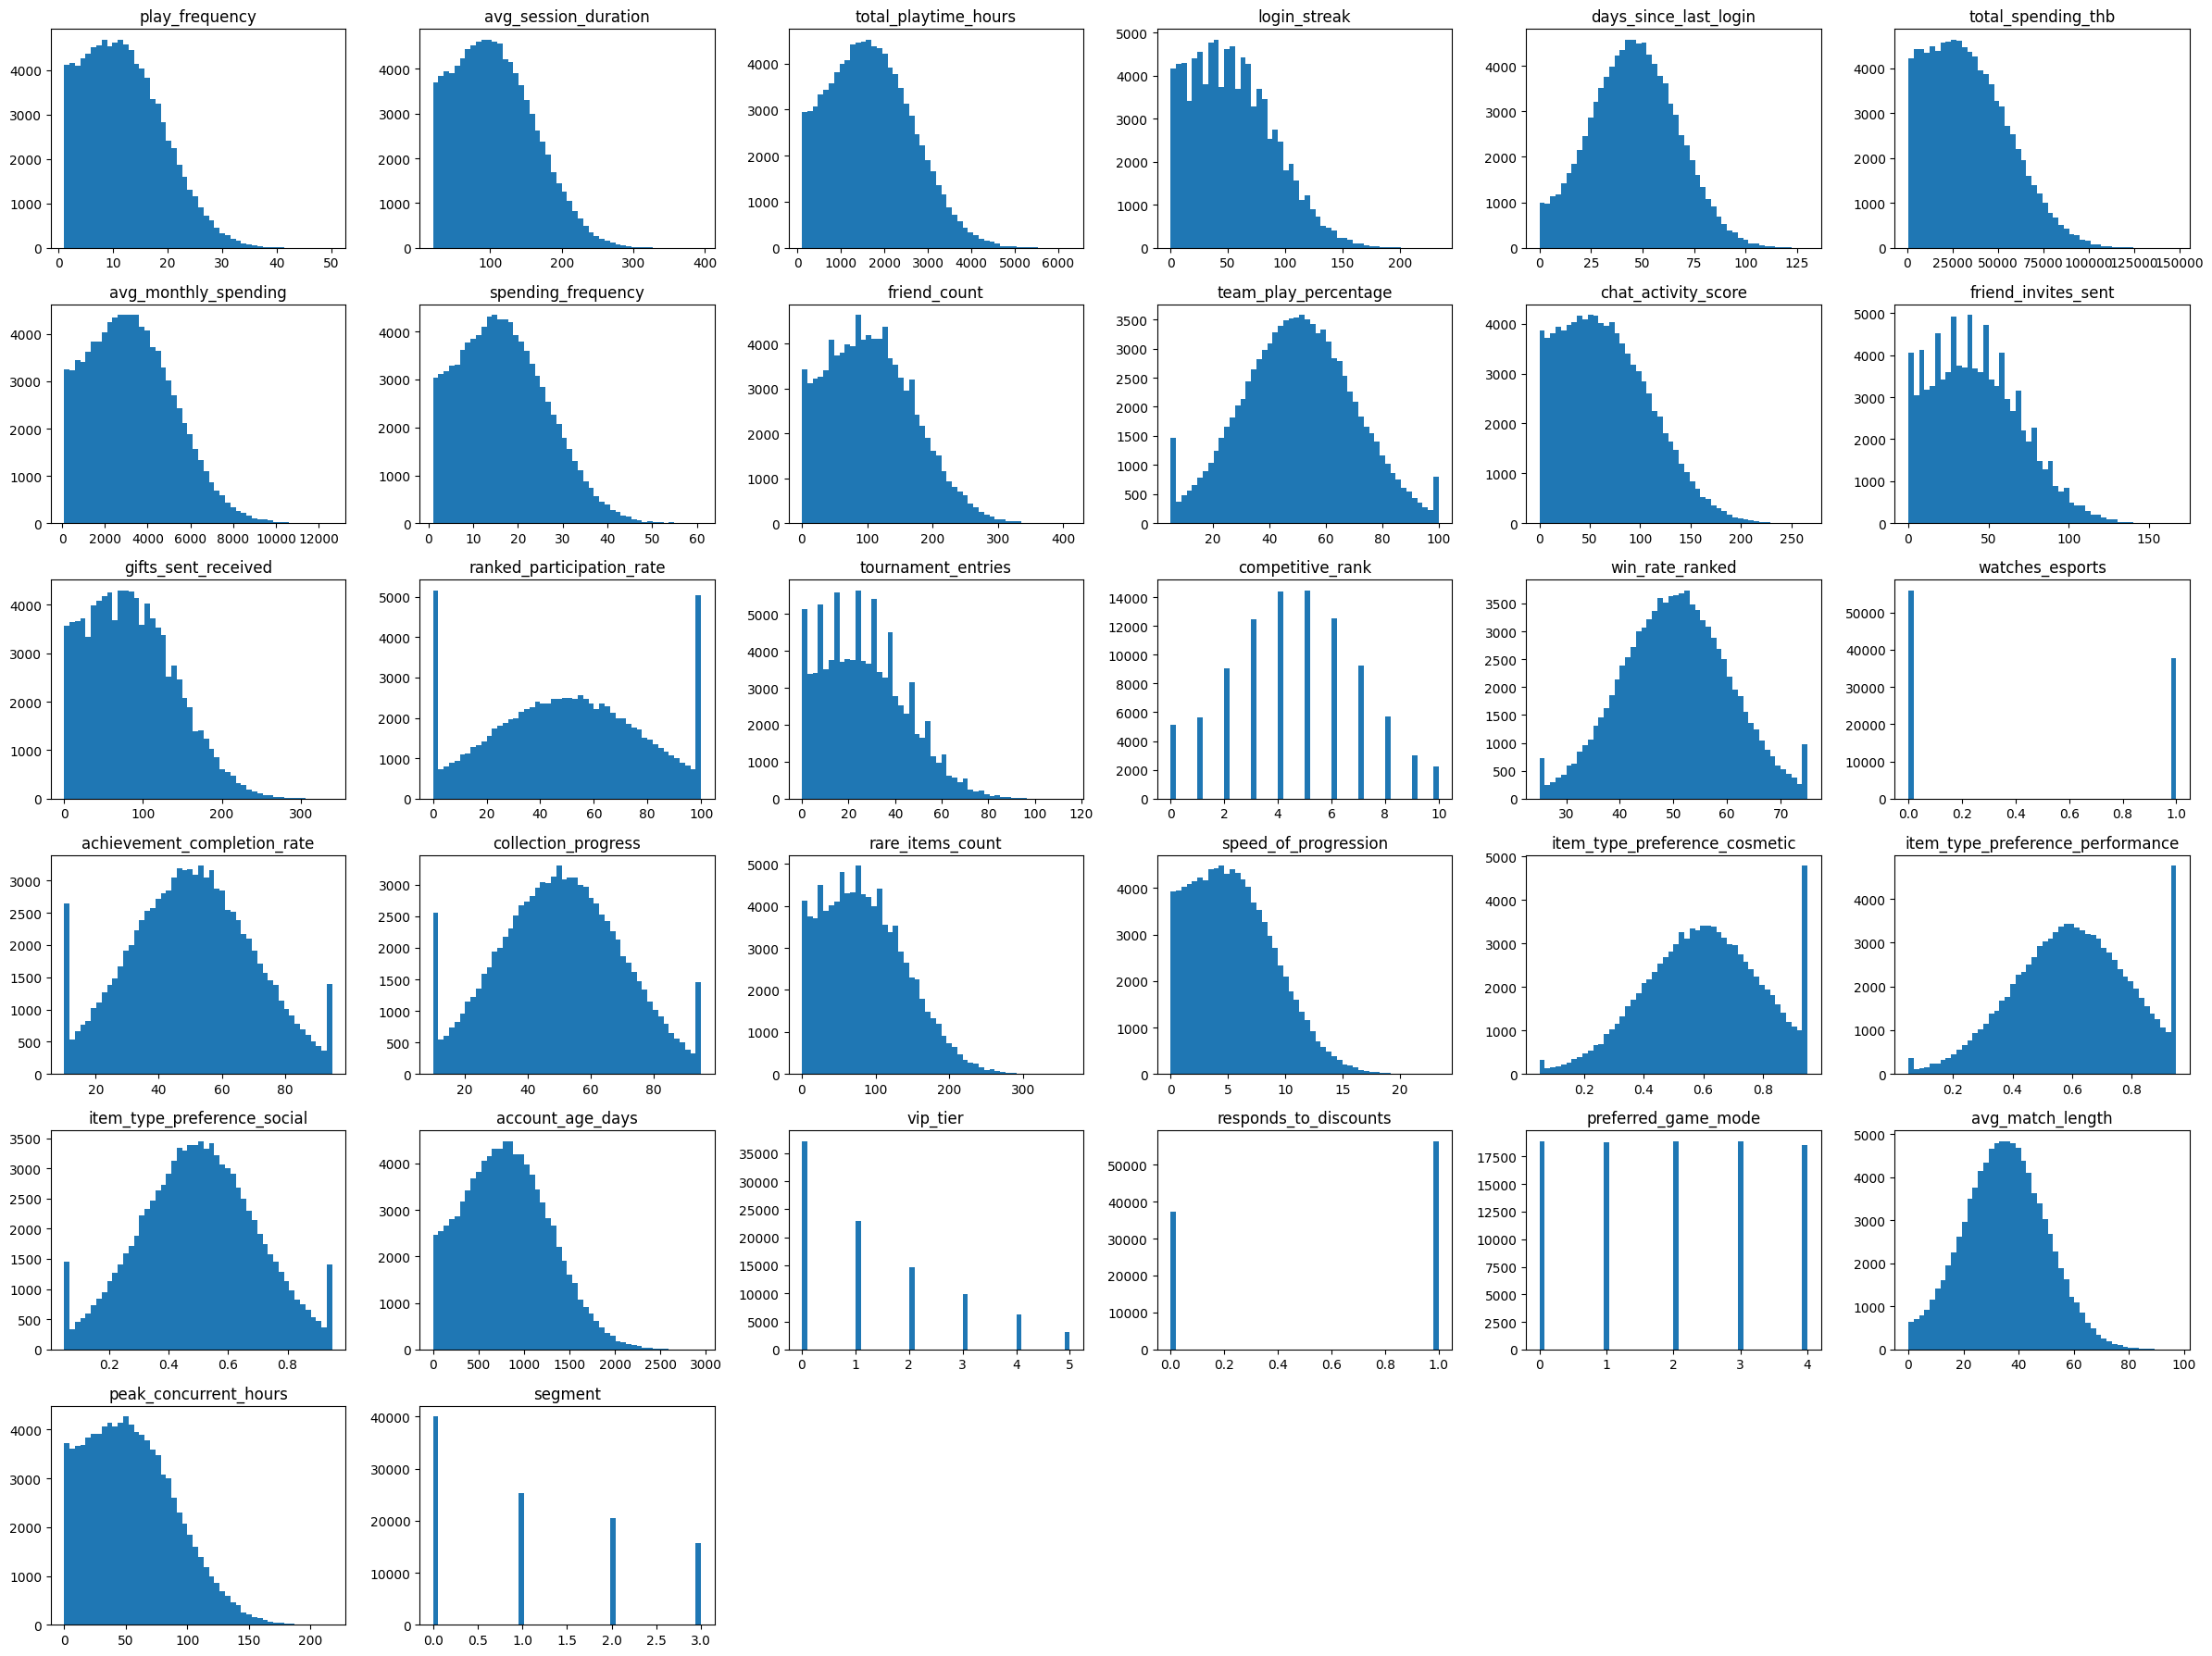

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def Plot_All_Histograms(df, bins = 50):
    numeric_cols = df.select_dtypes(include = np.number).columns
    n = len(numeric_cols)

    cols = 6 # number of subplots per row
    rows = int(np.ceil(n / cols))

    plt.figure(figsize = (cols*4, rows*3))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        plt.hist(df[col].dropna(), bins = bins)
        plt.title(col)
        plt.tight_layout()

    plt.show()

Plot_All_Histograms(df)

Note: Some numeric features seems like category

In [4]:
suspicious_cols = ["competitive_rank", "watches_esports", "vip_tier", 
              "responds_to_discounts", "preferred_game_mode"]

df[suspicious_cols].nunique()

competitive_rank         11
watches_esports           2
vip_tier                  6
responds_to_discounts     2
preferred_game_mode       5
dtype: int64

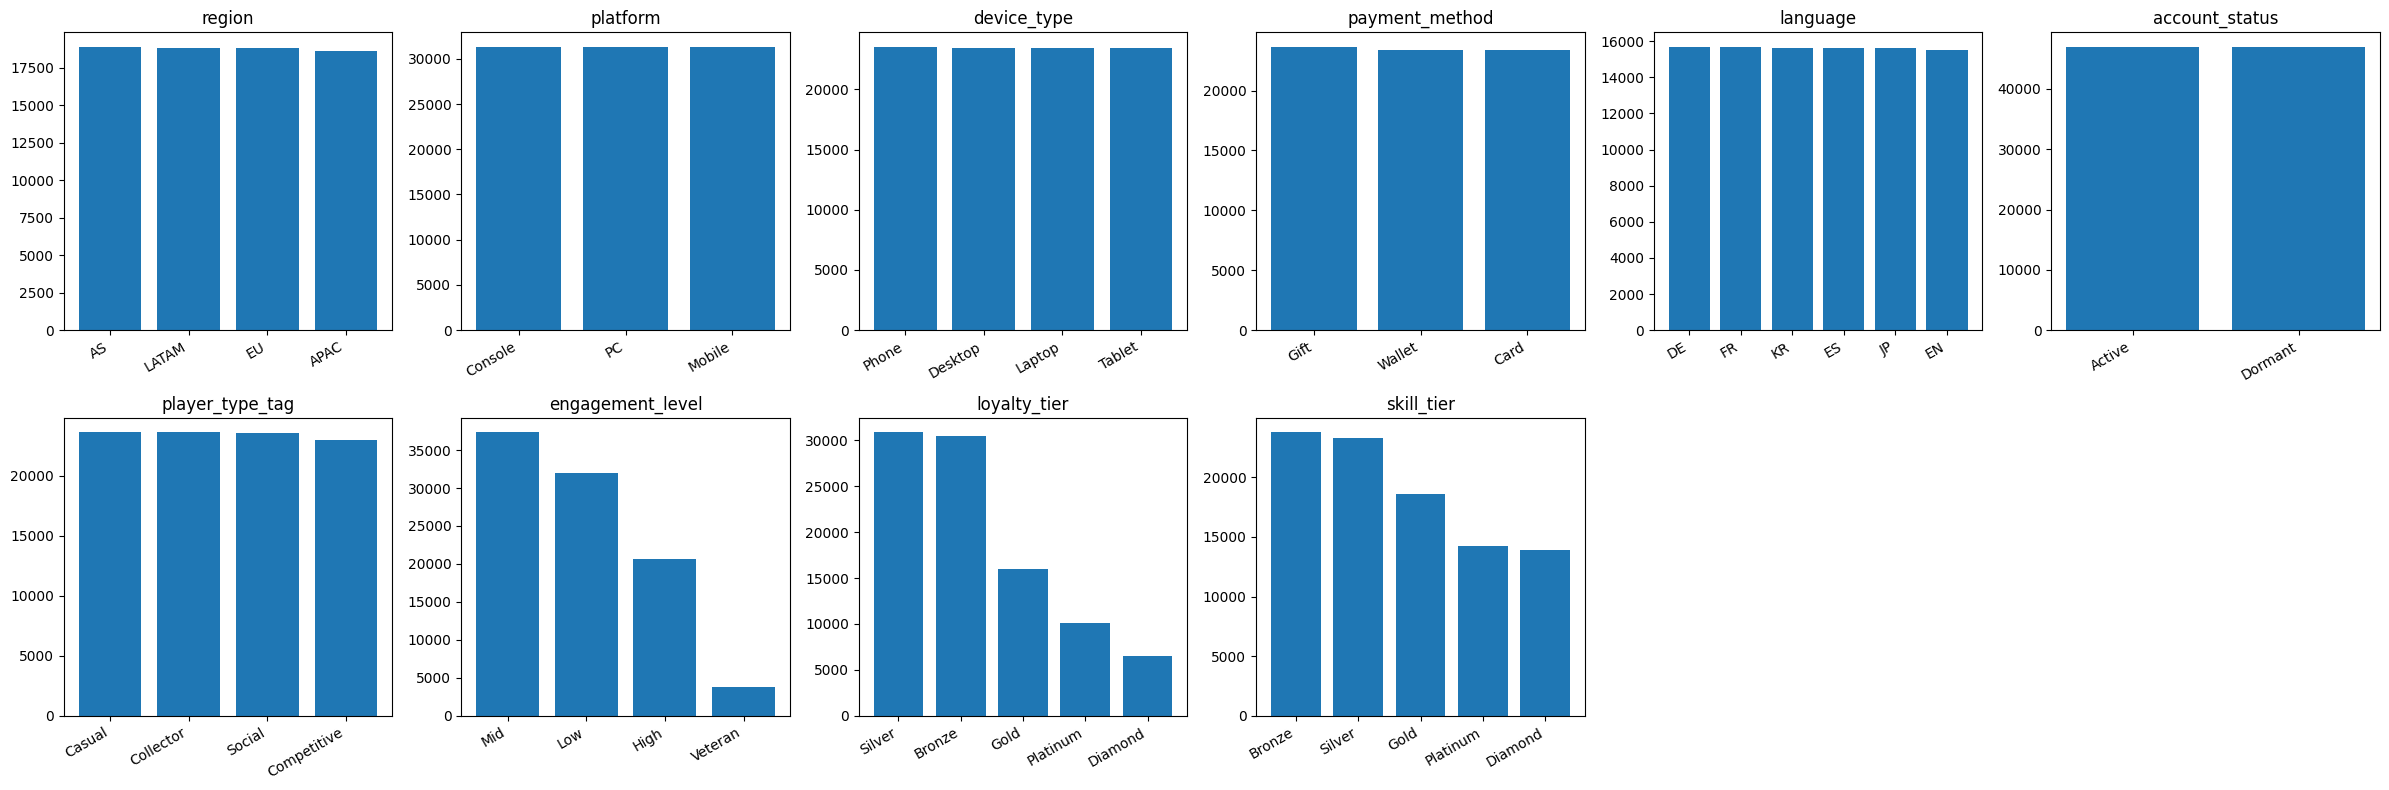

In [5]:
def Plot_All_Boxplots_Object(df, top_n = 20):
    obj_cols = df.select_dtypes(include = ["object"]).columns
    n = len(obj_cols)

    cols = 6 # subplots per row
    rows = int(np.ceil(n / cols))

    plt.figure(figsize = (cols * 4, rows * 4))

    for i, col in enumerate(obj_cols, 1):
        plt.subplot(rows, cols, i)

        counts = df[col].value_counts().head(top_n)

        plt.bar(counts.index.astype(str), counts.values)
        plt.title(col)
        plt.xticks(rotation = 30, ha = "right")

    plt.tight_layout()
    plt.show()

Plot_All_Boxplots_Object(df)

## Imbalance Check

Class counts:
 segment
0    40064
1    25397
2    20549
3    15648
Name: count, dtype: int64

Class distribution (%):
 segment
0    39.410573
1    24.982785
2    20.213854
3    15.392788
Name: proportion, dtype: float64


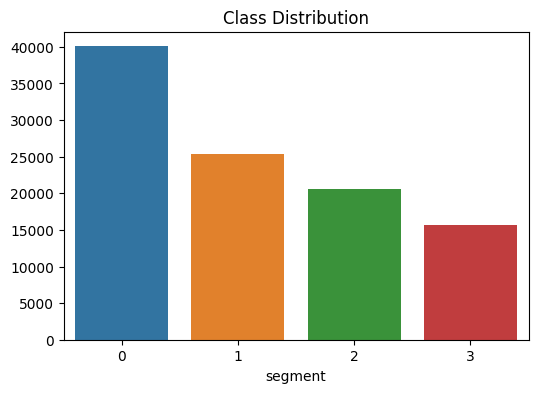


Imbalance ratio (max/min): 2.56


In [6]:
import seaborn as sns

class_counts = df["segment"].value_counts()
print("Class counts:\n", class_counts)

class_percent = df["segment"].value_counts(normalize = True) * 100
print("\nClass distribution (%):\n", class_percent)

plt.figure(figsize = (6,4))
sns.barplot(x = class_counts.index, y = class_counts.values)
plt.title("Class Distribution")
plt.show()

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("Warning: dataset may be imbalanced")
else:
    print("Dataset seems balanced")

## Imputation Method Check

In [7]:
numeric_cols = df.select_dtypes(include = np.number).columns

skew_threshold = 0.5

impute_decision = {}
for col in numeric_cols:
    skew = df[col].skew()
    strategy = "median" if abs(skew) > skew_threshold else "mean"
    impute_decision[col] = {"skew": skew, "impute_with": strategy}

impute_df = pd.DataFrame.from_dict(impute_decision, orient = "index")
print(impute_df)

                                      skew impute_with
play_frequency                    0.554082      median
avg_session_duration              0.498703        mean
total_playtime_hours              0.413384        mean
login_streak                      0.550238      median
days_since_last_login             0.119965        mean
total_spending_thb                0.597748      median
avg_monthly_spending              0.461031        mean
spending_frequency                0.457839        mean
friend_count                      0.457826        mean
team_play_percentage              0.032908        mean
chat_activity_score               0.563851      median
friend_invites_sent               0.505627      median
gifts_sent_received               0.503984      median
ranked_participation_rate        -0.001320        mean
tournament_entries                0.543513      median
competitive_rank                  0.092026        mean
win_rate_ranked                   0.002719        mean
watches_es

# Preprocessing

In [9]:
df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/train.csv")
test_df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/test.csv")

df.drop(columns = ["id", "player_id", "random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)
test_id = test_df["id"].copy()
test_df.drop(columns = ["id", "player_id"], inplace = True)

## Define Cols

In [10]:
numeric_cols = df.select_dtypes(include = np.number).columns.tolist()
numeric_cols.remove("segment")
suspicious_cols = ["competitive_rank", "watches_esports", "vip_tier", 
                   "responds_to_discounts", "preferred_game_mode"]
numeric_cols = list(set(numeric_cols) - set(suspicious_cols))

all_object_cols = df.select_dtypes(include = "object").columns.tolist()
ordinal_cols_given = {
    "engagement_level": ["Low", "Mid", "High", "Veteran"],
    "loyalty_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"],
    "skill_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"]
}
ordinal_cols = [c for c in ordinal_cols_given if c in all_object_cols]
nominal_cols = [c for c in all_object_cols if c not in ordinal_cols]

In [11]:
median_impute_cols = [
    "rare_items_count", "chat_activity_score", "friend_invites_sent", "total_spending_thb", 
    "login_streak", "tournament_entries", "speed_of_progression", "play_frequency", 
    "peak_concurrent_hours", "gifts_sent_received"
]
mean_impute_cols = list(set(numeric_cols) - set(median_impute_cols))

## Feature Engineering

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, eps = 1e-6):
        self.eps = eps
        self.created_features_ = []

    def fit(self, X, y = None):
        self.created_features_ = [
            "spend_per_play", "spend_per_hour", "monthly_spend_ratio", "friend_per_day",
            "tournament_rate", "play_intensity", "social_activity", "progression_per_day",
            "rare_item_ratio", "spending_frequency_ratio"
        ]
        return self

    def transform(self, X):
        X = X.copy()
        eps = self.eps

        # safe denominators
        X["play_frequency_safe"] = X["play_frequency"].replace(0, np.nan)
        X["total_playtime_hours_safe"] = X["total_playtime_hours"].replace(0, np.nan)
        X["account_age_days_safe"] = X["account_age_days"].replace(0, np.nan)
        X["collection_progress_safe"] = X["collection_progress"].replace(0, np.nan)
        
        # engineered features
        X["spend_per_play"] = X["total_spending_thb"] / (X["play_frequency_safe"].fillna(eps))
        X["spend_per_hour"] = X["total_spending_thb"] / (X["total_playtime_hours_safe"].fillna(eps))
        X["monthly_spend_ratio"] = X["avg_monthly_spending"] / (X["avg_session_duration"].replace(0, eps).fillna(eps))
        X["friend_per_day"] = X["friend_count"] / (X["account_age_days_safe"].fillna(eps))
        X["tournament_rate"] = X["tournament_entries"] / (X["account_age_days_safe"].fillna(eps))
        X["play_intensity"] = X["play_frequency"] * X["avg_session_duration"]
        X["social_activity"] = (X["chat_activity_score"].fillna(0)
                                + X["friend_invites_sent"].fillna(0)
                                + X["gifts_sent_received"].fillna(0))
        X["progression_per_day"] = X["speed_of_progression"] / (X["account_age_days_safe"].fillna(eps))
        X["rare_item_ratio"] = X["rare_items_count"] / (X["collection_progress_safe"].fillna(eps))
        X["spending_frequency_ratio"] = X["spending_frequency"] / (X["play_frequency_safe"].fillna(eps))

        # clean up temporary cols
        X = X.drop(columns = [
            "play_frequency_safe", "total_playtime_hours_safe",
            "account_age_days_safe", "collection_progress_safe"
        ], errors = "ignore")

        # handle error from division
        X[self.created_features_] = X[self.created_features_].replace([np.inf, -np.inf], np.nan)
        X[self.created_features_] = X[self.created_features_].astype(float)

        return X

In [14]:
engineered_cols = FeatureEngineer().fit(df.drop(columns = ["segment"])).created_features_
median_impute_cols_all = list(set(median_impute_cols) | set(engineered_cols))

In [17]:
X_full = df.drop(columns=["segment"]).copy()
X_full_fe = FeatureEngineer().fit_transform(X_full)
y_full = df["segment"].copy().values

n_classes = len(np.unique(y_full))
seed = 42

all_cols_after_fe = X_full_fe.columns.tolist()

# Update all grouping lists to include engineered features where appropriate
mean_impute_cols_full = [c for c in all_cols_after_fe if c in mean_impute_cols]
median_impute_cols_full = [c for c in all_cols_after_fe if c in median_impute_cols_all]
suspicious_cols_full = [c for c in all_cols_after_fe if c in suspicious_cols]
ordinal_cols_full = [c for c in all_object_cols if c in ordinal_cols] # Use only non-FE ordinal columns
nominal_cols_full = [c for c in all_object_cols if c in nominal_cols] # Use only non-FE nominal columns

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_mean_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "mean")),
    ("power", PowerTransformer(method = "yeo-johnson")),
    ("scaler", StandardScaler())
])

num_median_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("power", PowerTransformer(method = "yeo-johnson")),
    ("scaler", StandardScaler())
])

suspicious_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("scaler", StandardScaler())
])

full_preprocessor = ColumnTransformer(transformers = [
    ("num_mean", num_mean_pipeline, mean_impute_cols_full),
    ("num_median", num_median_pipeline, median_impute_cols_full),
    ("suspicious", suspicious_pipeline, suspicious_cols_full),
    ("ordinal", Pipeline([
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("encoder", OrdinalEncoder(categories = [ordinal_cols_given[c] for c in ordinal_cols_full])),
    ]), ordinal_cols_full),
    ("nominal", Pipeline([
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown = "ignore")),
    ]), nominal_cols_full),
], remainder="drop", sparse_threshold = 0)

# Create a pipeline to transform data for feature selection
fe_preproc_pipeline = Pipeline([
    ("fe", FeatureEngineer()),
    ("preproc", full_preprocessor)
])

X_transformed = fe_preproc_pipeline.fit_transform(X_full, y_full)

In [30]:
# Get the names of the transformed features
def get_transformed_feature_names(column_transformer):
    output_features = []
    for name, estimator, cols in column_transformer.transformers_:
        if name in ["remainder", "drop"]:
            continue
        if hasattr(estimator, "get_feature_names_out"):
            output_features.extend(estimator.get_feature_names_out(cols))
        else:
            output_features.extend(cols)
    return output_features

feature_names = get_transformed_feature_names(full_preprocessor)
X_transformed_df = pd.DataFrame(X_transformed, columns = feature_names)
print(f"Transformed data shape for selection: {X_transformed_df.shape}")

Transformed data shape for selection: (101658, 70)


# Feature Selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from scipy.stats import spearmanr

N_TOP_FEATURES = 30
selected_sets = {}

# XGBoost Feature Importance
print("XGBoost")
xgb_model = XGBClassifier(n_estimators = 100, use_label_encoder = False, 
                          eval_metric = "mlogloss", random_state = seed, n_jobs = -1)
xgb_model.fit(X_transformed_df, y_full)
xgb_importances = pd.Series(xgb_model.feature_importances_, 
                            index = feature_names).sort_values(ascending = False)
selected_sets["xgb_importance"] = set(xgb_importances.head(N_TOP_FEATURES).index)

# Permutation Importance (Random Forest)
print("Permutation Importance")
rf_model_for_pi = RandomForestClassifier(n_estimators = 100, random_state = seed, n_jobs = -1)
rf_model_for_pi.fit(X_transformed_df, y_full)
perm_importance = permutation_importance(
    rf_model_for_pi, X_transformed_df, y_full, n_repeats = 10, random_state = seed, n_jobs = 1, 
    scoring = "f1_macro"
)
pi_importances = pd.Series(perm_importance.importances_mean, 
                           index = feature_names).sort_values(ascending = False)
selected_sets["perm_importance"] = set(pi_importances.head(N_TOP_FEATURES).index)

# L1 Regularization (Logistic Regression)
print("Logistic Regression")
logreg = LogisticRegression(penalty = "l1", C = 0.1, solver = "saga", multi_class = "multinomial", 
                            max_iter = 5000, random_state = seed)
logreg.fit(X_transformed_df, y_full)
model_sfm = SelectFromModel(logreg, prefit = True, threshold = 1e-5)
logreg_selected = X_transformed_df.columns[model_sfm.get_support()]
selected_sets['logreg_l1'] = set(logreg_selected)

# Univariate Selection (Mutual Information)
print("Mutual Information")
mi_scores = mutual_info_classif(X_transformed_df, y_full, random_state = seed)
mi_series = pd.Series(mi_scores, index = feature_names).sort_values(ascending = False)
selected_sets['mutual_info'] = set(mi_series.head(N_TOP_FEATURES).index)

# Spearman Correlation (on untransformed numerical/ordinal features)
print("Spearman Correlation")
numeric_features_for_corr = list(set(median_impute_cols_full) | set(mean_impute_cols_full) | set(engineered_cols))
X_corr_check = X_full_fe[numeric_features_for_corr].select_dtypes(include = np.number).copy()
X_corr_check = X_corr_check.fillna(X_corr_check.median())

spearman_scores = {}
y_dummies = pd.get_dummies(y_full).values

for col in X_corr_check.columns:
    max_corr = 0
    for k in range(n_classes):
        corr, _ = spearmanr(X_corr_check[col].values, y_dummies[:, k])
        max_corr = max(max_corr, abs(corr))
    spearman_scores[col] = max_corr

spearman_series = pd.Series(spearman_scores).sort_values(ascending = False)
selected_sets["spearman"] = set(spearman_series.head(N_TOP_FEATURES).index)

XGBoost
Permutation Importance


## Feature Union and Mapping

In [ ]:
union_features_transformed = set().union(*selected_sets.values())
original_features_in_union = set()

for t_feat in union_features_transformed:
    is_ohe = False
    for name, _, cols in full_preprocessor.transformers_:
        if name == "nominal":
            for col in cols:
                if t_feat.startswith(col + "_"):
                    original_features_in_union.add(col)
                    is_ohe = True
                    break
            if is_ohe: continue
    
    if not is_ohe:
        # Check if the feature is one of the original feature names
        if t_feat in X_full_fe.columns:
             original_features_in_union.add(t_feat)
        # Handle features created by PowerTransformer/StandardScaler
        # They retain the original feature name if not OHE
        else:
             original_features_in_union.add(t_feat)

# Final clean list of selected features
selected_features = list(original_features_in_union)

In [ ]:
print(f"\nTotal selected original features (Union): {len(selected_features)}")
print("Selected features:", selected_features)

mean_impute_cols_selected = [c for c in mean_impute_cols_full if c in selected_features]
median_impute_cols_selected = [c for c in median_impute_cols_full if c in selected_features]
suspicious_cols_selected = [c for c in suspicious_cols_full if c in selected_features]
ordinal_cols_selected = [c for c in ordinal_cols_full if c in selected_features]
nominal_cols_selected = [c for c in nominal_cols_full if c in selected_features]

# The Stack Modeling

## Pipeline

In [ ]:
ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("encoder", OrdinalEncoder(
        categories = [ordinal_cols_given[c] for c in ordinal_cols_selected]
    ))
])

nominal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown = "ignore"))
])

# Final preprocessor with ONLY selected features
preprocessor_selected = ColumnTransformer(transformers = [
    ("num_mean", num_mean_pipeline, mean_impute_cols_selected),
    ("num_median", num_median_pipeline, median_impute_cols_selected),
    ("suspicious", suspicious_pipeline, suspicious_cols_selected),
    ("ordinal", ordinal_pipeline, ordinal_cols_selected),
    ("nominal", nominal_pipeline, nominal_cols_selected),
], remainder = "drop", sparse_threshold = 0)

## Base Modeling & OOF Stacking Execution

In [ ]:
from collections import Counter
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

# Class weights for CatBoost
y_train = df["segment"].copy()
counter = Counter(y_train)
classes = sorted(counter.keys())
counts = np.array([counter[c] for c in classes], dtype = float)
N = counts.sum()
K = len(classes)
catboost_weights = (N / (K * counts)).tolist()
print("CatBoost numeric class_weights:", catboost_weights)

seed = 42
fe_step = ("fe", FeatureEngineer()) 

# --- CatBoost Pipeline ---
cat_model = CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.05,
    depth = 6,
    eval_metric = "MultiClass",
    random_state = seed,
    verbose = 0,
    class_weights = catboost_weights
)
cat_pipeline = Pipeline([
    fe_step,
    ("preproc", preprocessor_selected),
    ("clf", cat_model)
])

# --- Random Forest Pipeline ---
rf_model = RandomForestClassifier(
    n_estimators = 400,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = seed
)
rf_pipeline = Pipeline([
    fe_step,
    ("preproc", preprocessor_selected),
    ("clf", rf_model)
])

# --- SVM Pipeline (Using class_weight = "balanced") ---
svm_model = SVC(probability = True, class_weight = "balanced", random_state = seed)
svm_pipeline = Pipeline([
    fe_step,
    ("preproc", preprocessor_selected),
    ("clf", svm_model)
])

# --- MLP Pipeline ---
mlp_model = MLPClassifier(hidden_layer_sizes = (200,), max_iter = 1000, random_state = seed)
mlp_pipeline = Pipeline([
    fe_step,
    ("preproc", preprocessor_selected),
    ("clf", mlp_model)
])

base_pipelines = {
    "catboost": cat_pipeline,
    "random_forest": rf_pipeline,
    "svm": svm_pipeline,
    "mlp": mlp_pipeline
}

print("Base pipelines defined successfully.")

In [ ]:
from sklearn.model_selection import StratifiedKFold

# OOF Stacking Execution ---
X = df.drop(columns = ["segment"]).copy()
y = df["segment"].copy().values
n_samples = X.shape[0]
model_names = list(base_pipelines.keys())
n_models = len(model_names)
n_splits = 5
kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)

# OOF arrays
oof_train = np.zeros((n_samples, n_models * n_classes), dtype=float)
oof_test_folds = np.zeros((n_splits, test_df.shape[0], n_models * n_classes), dtype = float)
per_model_val_scores = {name: [] for name in model_names}

In [ ]:
from sklearn.metrics import f1_score

print("Starting OOF generation:")
for m_idx, (model_name, pipeline) in enumerate(base_pipelines.items()):
    print(f"\nModel {m_idx+1}/{n_models}: {model_name}")
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f" Fold {fold_idx+1}/{n_splits} ...", end = "")
        
        # Prepare fold data
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y[val_idx]

        # Fit and Predict probabilities
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Get probabilities for OOF train and test prediction
        proba_val = pipeline.predict_proba(X_val_fold)
        proba_test = pipeline.predict_proba(test_df)

        # Place into OOF_train
        start_col = m_idx * n_classes
        end_col = start_col + n_classes
        oof_train[val_idx, start_col:end_col] = proba_val
        
        # Store test probabilities for this fold
        oof_test_folds[fold_idx, :, start_col:end_col] = proba_test

        # Fold score
        preds_val = np.argmax(proba_val, axis=1)
        fold_f1 = f1_score(y_val_fold, preds_val, average = "macro")
        per_model_val_scores[model_name].append(fold_f1)
        print(f" val_f1_macro = {fold_f1:.4f}")

In [ ]:
# Averaged test meta-features
oof_test = oof_test_folds.mean(axis = 0)

print("\nShapes:")
print(" oof_train:", oof_train.shape)
print(" oof_test :", oof_test.shape)

print("\nPer-base-model mean val F1-macro:")
for name in model_names:
    scores = per_model_val_scores[name]
    print(f" {name}: mean = {np.mean(scores):.4f}, folds = {scores}")

## Meta-Learner Modeling & Inference

In [ ]:
meta_clf = LogisticRegression(class_weight = "balanced", max_iter = 5000, random_state = seed)

# CV on OOF_train
meta_cv_scores = []
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(oof_train, y)):
    meta_clf.fit(oof_train[train_idx], y[train_idx])
    preds_val = meta_clf.predict(oof_train[val_idx])
    score = f1_score(y[val_idx], preds_val, average = "macro")
    meta_cv_scores.append(score)
print(" Meta CV mean f1_macro:", np.mean(meta_cv_scores))

meta_clf.fit(oof_train, y)

In [ ]:
meta_test_pred = meta_clf.predict(oof_test)

submission = pd.DataFrame({
    "id": test_id,
    "segment": meta_test_pred
})

submission.to_csv("submission.csv", index = False)

In [ ]:
import joblib

for name, pipeline in fitted_base_pipelines:
    filename = f"stacking_base_{name}_pipeline.joblib"
    joblib.dump(pipeline, filename)
    print(f" Saved base pipeline: {filename}")

joblib.dump(meta_clf, "stacking_meta_learner.joblib")
print("Saved meta-learner")

# loaded_meta = joblib.load("stacking_meta_learner.joblib")
# loaded_base_cat = joblib.load("stacking_base_catboost_pipeline.joblib")